
## This notebook shows how to use Grizli to

Retrieve and reduce raw CLEAR G102/F105W and 3D-HST G141/F140W observations for a specific CLEAR pointing (GS1).
        
** more comments inbound

These series of notebooks draw heavily from Gabe Brammer's existing grizli notebooks, which are available at https://github.com/gbrammer/grizli/tree/master/examples, but with specific focus for the CLEAR survey.

In [1]:
import grizli

try: 
    from mastquery import query, overlaps
    use_mquery = True
except: 
    from hsaquery import query, overlaps
    use_mquery = False

import os
import numpy as np
from grizli.pipeline import auto_script
import glob
from glob import glob
import astropy
from grizli.prep import process_direct_grism_visit
from astropy.io import fits


## The paths defined below need to be changed to your own directories.
### the PATH_TO_CATS directory should include the following:
        ###     reference mosaic image (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sci.fits)
        ###     segmentation map       (e.g., Goods_S_plus_seg.fits)
        ###     source catalog         (e.g., goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat)
        ###     radec_catalog          (e.g., goodsS_radec.cat)
        ###     3DHST Eazy Catalogs    (e.g., goodss_3dhst.v4.1.cats/*)
### these are all available on the team archive: https://archive.stsci.edu/pub/clear_team/INCOMING/for_hackday/
### the HOME_PATH directory is where the raw data, reduced data, and grizli outputs will be stored


In [2]:
field           = 'GS1'
ref_filter      = 'F105W'

HOME_PATH       = '/Users/rsimons/Desktop/clear/for_hackday/%s'%field
PATH_TO_CATS    = '/Users/rsimons/Desktop/clear/Catalogs'

if not os.path.isdir(HOME_PATH): os.system('mkdir %s'%HOME_PATH)
if not os.path.isdir(HOME_PATH + '/query_results'): os.system('mkdir %s/query_results'%HOME_PATH)

os.chdir(HOME_PATH)


## Run an initial query for all raw G102 data in the ESA archive with a target name that includes the phrase 'GS1' and a proposal ID of 14227 (i.e., GS1 pointing of CLEAR). 

In [16]:
if True:
    # The parent query targets only the G102 observations in the CLEAR pointing 'GS1'

    if use_mquery:
        extra = {'target_name':field}
    else:
        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%field]

    # proposid 14227 = CLEAR
    #parent = query.run_query(box = None, proposid = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
    #                     extensions=['FLT'], filters=['G102'], extra = {'target_name':field})
    #parent = query.run_query(box=None, proposal_id=[11359], instruments=['WFC3/IR', 'ACS/WFC'], 
    #                     filters=['G102','G141'])

    parent = query.run_query(box = None, proposal_id = [14227], instruments=['WFC3/IR', 'ACS/WFC'], 
                             filters = ['G102'], target_name = 'GS1')

## Then, find all overlapping G102 and G141 observations.

Iter #1, N_Patch = 1


 0 j0333m2742 53.24696550387 -27.69263492857333
 target_name 
-------------
GOODS-SOUTH-1
          GS1 

filter j0333m2742          WFC3/IR G102    6   27670.5
filter j0333m2742          WFC3/IR G141    1    4711.7


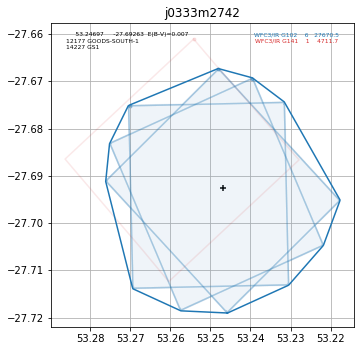

In [17]:
if True:
    # Finding all overlapping G102 and G141 observations in the archive
    tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                                  filters=['G102', 'G141'], 
                                  instruments=['WFC3/IR','WFC3/UVIS','ACS/WFC'], close=False)

    footprint_fits_file = glob('*footprint.fits')[0]
    jtargname = footprint_fits_file.strip('_footprint.fits')

    fp_fits = fits.open(footprint_fits_file)

    overlapping_target_names = set(fp_fits[1].data['target'])
    s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
    
    # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
    os.system('cp %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, 'all_G102_G141'))
    os.system('cp %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
    os.system('cp %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))
    os.system('cp %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname,  'all_G102_G141'))


## We now have a list of the target names for the G102 and G141 observations in the ESA archive that overlap with the GS1 pointing of CLEAR. 

### For each target name, search the archive and retrieve all associated grism G102/G141 and direct imaging F098M/F105W/F125W/F140W observations.

**For GS1, the retrieval step takes about 30 minutes to run and requires 1.9 GB of space.


In [ ]:
if True:
    for t, targ_name in enumerate(overlapping_target_names):

        extra = query.DEFAULT_EXTRA.copy()
        extra += ["TARGET.TARGET_NAME LIKE '%s'"%field]
        # search the ESA archive for overlapping grism and direct imaging observations with that target name
        tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, filters=['G102', 'G141', 'F098M', 'F105W', 'F125W', 'F140W'], 
                                      instruments=['WFC3-IR','WFC3-UVIS','ACS-WFC'], extra=extra, close=False)
        s3_status = os.system('aws s3 ls s3://stpubdata --request-payer requester')
        
        #retrieve the raw data products
        auto_script.fetch_files(field_root=jtargname, HOME_PATH=HOME_PATH, remove_bad=True, 
                                reprocess_parallel=True, s3_sync=(s3_status == 0))
        
        # Move the figure files to $HOME_PATH/query_results/ so that they are not overwritten
        os.system('mv %s/%s_footprint.fits %s/query_results/%s_footprint_%s.fits'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_footprint.npy %s/query_results/%s_footprint_%s.npy'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_footprint.pdf %s/query_results/%s_footprint_%s.pdf'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))
        os.system('mv %s/%s_info.dat %s/query_results/%s_info_%s.dat'%(HOME_PATH, jtargname, HOME_PATH, jtargname, targ_name))

        os.chdir(HOME_PATH)

In [ ]:
# PATH_TO_RAW and PATH_TO_PREP are created in the previous steps
PATH_TO_RAW     = glob(HOME_PATH + '/*/RAW')[0]
PATH_TO_PREP    = glob(HOME_PATH + '/*/PREP')[0]


class Pointing():
    """ Generalization of GN1, GS1, ERSPRIME, etc

    To change field-dependent catalog, seg map, ref image, and padding
    only need to change them here.

    """
    def __init__(self, field, ref_filter):
        if 'N' in field.upper():
            self.pad = 500
            self.radec_catalog = PATH_TO_CATS + '/old_radeccats/goodsN_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_N_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits'
            
            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodsn_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodsn', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodsn', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodsn']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodsn', 'v4.1')

        elif 'S' in field.upper():
            self.pad = 200 # grizli default
            self.radec_catalog =  PATH_TO_CATS + '/old_radeccats/goodsS_radec.cat'
            self.seg_map =  PATH_TO_CATS + '/Goods_S_plus_seg.fits'
            self.catalog =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sub_plus.cat'
            self.ref_image =  PATH_TO_CATS + '/goodss-F105W-astrodrizzle-v4.3_drz_sci.fits'


            self.tempfilt, self.coeffs, self.temp_sed, self.pz = readEazyBinary(MAIN_OUTPUT_FILE='goodss_3dhst.v4.1', OUTPUT_DIRECTORY=PATH_TO_CATS, CACHE_FILE='Same')
            self.params = {}
            self.params['CATALOG_FILE'] = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format('goodss', 'v4.1')
            self.params['Z_STEP'] = 0.002
            self.params['Z_MAX'] = 4
            self.params['MAIN_OUTPUT_FILE'] = '{0}_3dhst.{1}.eazypy'.format('goodss', 'v4.1')
            self.params['PRIOR_FILTER'] = 205
            self.params['MW_EBV'] = {'aegis':0.0066, 'cosmos':0.0148, 'goodss':0.0069, 
                                    'uds':0.0195, 'goodsn':0.0103}['goodss']
            self.params['TEMPLATES_FILE'] = 'templates/fsps_full/tweak_fsps_QSF_12_v3.param'
            self.translate_file = PATH_TO_CATS + '/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.translate'.format('goodss', 'v4.1')




def readEazyBinary(MAIN_OUTPUT_FILE='photz', OUTPUT_DIRECTORY='./OUTPUT', CACHE_FILE='Same'):

    """
    Author: Gabe Brammer
    This function has been clipped from eazyPy.py in thethreedhst git respository
    https://github.com/gbrammer/threedhst/tree/master/threedhst

    tempfilt, coeffs, temp_sed, pz = readEazyBinary(MAIN_OUTPUT_FILE='photz', \
                                                OUTPUT_DIRECTORY='./OUTPUT', \
                                                CACHE_FILE = 'Same')

    Read Eazy BINARY_OUTPUTS files into structure data.
    
    If the BINARY_OUTPUTS files are not in './OUTPUT', provide either a relative or absolute path
    in the OUTPUT_DIRECTORY keyword.
    
    By default assumes that CACHE_FILE is MAIN_OUTPUT_FILE+'.tempfilt'.
    Specify the full filename if otherwise. 
    """
    
    #root='COSMOS/OUTPUT/cat3.4_default_lines_zp33sspNoU'
    
    root = OUTPUT_DIRECTORY+'/'+MAIN_OUTPUT_FILE
    
    ###### .tempfilt
    if CACHE_FILE == 'Same':
        CACHE_FILE = root+'.tempfilt'
    
    if os.path.exists(CACHE_FILE) is False:
        print(('File, %s, not found.' %(CACHE_FILE)))
        return -1,-1,-1,-1
    
    f = open(CACHE_FILE,'rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    tempfilt = np.fromfile(file=f,dtype=np.double,count=NFILT*NTEMP*NZ).reshape((NZ,NTEMP,NFILT)).transpose()
    lc = np.fromfile(file=f,dtype=np.double,count=NFILT)
    zgrid = np.fromfile(file=f,dtype=np.double,count=NZ)
    fnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    efnu = np.fromfile(file=f,dtype=np.double,count=NFILT*NOBJ).reshape((NOBJ,NFILT)).transpose()
    
    f.close()
    
    tempfilt  = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
                 'tempfilt':tempfilt,'lc':lc,'zgrid':zgrid,'fnu':fnu,'efnu':efnu}
    
    ###### .coeff
    f = open(root+'.coeff','rb')
    
    s = np.fromfile(file=f,dtype=np.int32, count=4)
    NFILT=s[0]
    NTEMP=s[1]
    NZ=s[2]
    NOBJ=s[3]
    coeffs = np.fromfile(file=f,dtype=np.double,count=NTEMP*NOBJ).reshape((NOBJ,NTEMP)).transpose()
    izbest = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
    tnorm = np.fromfile(file=f,dtype=np.double,count=NTEMP)
    
    f.close()
    
    coeffs = {'NFILT':NFILT,'NTEMP':NTEMP,'NZ':NZ,'NOBJ':NOBJ,\
              'coeffs':coeffs,'izbest':izbest,'tnorm':tnorm}
              
    ###### .temp_sed
    f = open(root+'.temp_sed','rb')
    s = np.fromfile(file=f,dtype=np.int32, count=3)
    NTEMP=s[0]
    NTEMPL=s[1]
    NZ=s[2]
    templam = np.fromfile(file=f,dtype=np.double,count=NTEMPL)
    temp_seds = np.fromfile(file=f,dtype=np.double,count=NTEMPL*NTEMP).reshape((NTEMP,NTEMPL)).transpose()
    da = np.fromfile(file=f,dtype=np.double,count=NZ)
    db = np.fromfile(file=f,dtype=np.double,count=NZ)
    
    f.close()
    
    temp_sed = {'NTEMP':NTEMP,'NTEMPL':NTEMPL,'NZ':NZ,\
              'templam':templam,'temp_seds':temp_seds,'da':da,'db':db}
              
    ###### .pz
    if os.path.exists(root+'.pz'):
        f = open(root+'.pz','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=2)
        NZ=s[0]
        NOBJ=s[1]
        chi2fit = np.fromfile(file=f,dtype=np.double,count=NZ*NOBJ).reshape((NOBJ,NZ)).transpose()

        ### This will break if APPLY_PRIOR No
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        
        if len(s) > 0:
            NK = s[0]
            kbins = np.fromfile(file=f,dtype=np.double,count=NK)
            priorzk = np.fromfile(file=f, dtype=np.double, count=NZ*NK).reshape((NK,NZ)).transpose()
            kidx = np.fromfile(file=f,dtype=np.int32,count=NOBJ)
            pz = {'NZ':NZ,'NOBJ':NOBJ,'NK':NK, 'chi2fit':chi2fit, 'kbins':kbins, 'priorzk':priorzk,'kidx':kidx}
        else:
            pz = None
        
        f.close()
        
    else:
        pz = None
    
    if False:
        f = open(root+'.zbin','rb')
        s = np.fromfile(file=f,dtype=np.int32, count=1)
        NOBJ=s[0]
        z_a = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_p = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m1 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_m2 = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        z_peak = np.fromfile(file=f,dtype=np.double,count=NOBJ)
        f.close()
        
    ###### Done.    
    return tempfilt, coeffs, temp_sed, pz



In [ ]:
os.chdir(PATH_TO_PREP)
files = glob('%s/*flt.fits'%PATH_TO_RAW)
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)


In [ ]:
if True:
    product_names = np.array([visit['product'] for visit in visits])
    filter_names = np.array([visit['product'].split('-')[-1] for visit in visits])
    basenames = np.array([visit['product'].split('.')[0]+'.0' for visit in visits])




    for ref_grism, ref_filter in [('G102', 'F105W'), ('G141', 'F140W')]:
        print(ref_grism, ref_filter)

        for v, visit in enumerate(visits):
            product = product_names[v]
            basename = basenames[v]
            filt1 = filter_names[v]
            field_in_contest = basename.split('-')[0]
            if (ref_filter.lower() == filt1.lower()):
                #Found a direct image, now search for grism counterpart
                grism_index= np.where((basenames == basename) & (filter_names == ref_grism.lower()))[0][0]
                p = Pointing(field = field, ref_filter = ref_filter)
                radec_catalog = p.radec_catalog
                print (field_in_contest, visits[grism_index])
                status = process_direct_grism_visit(direct = visit,
                                                    grism = visits[grism_index],
                                                    radec = radec_catalog, 
                                                    align_mag_limits = [14, 23])



In [ ]:
x = tabs[0]

In [ ]:
x.colnames